In [1]:
import os
from os.path import join
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import scipy.io.wavfile as wav

from laughter_classification.utils import chunks, in_any, interv_to_range, get_sname
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.sample_audio import sample_wav_by_time
from laughter_prediction.feature_extractors import FeatureExtractor
from sklearn import metrics

import matplotlib.pyplot as plt
import IPython.display
from scipy.io import wavfile

from tensorboardX import SummaryWriter

In [2]:
import wave
import contextlib

def sampling_data(corpus_root):
        feature_extractor = FeatureExtractor()
        data_sampler = SSPNetDataSampler(corpus_root)
        data = []
        for filename in data_sampler.get_valid_wav_paths():
            duration = 11
            samples_count = 474 # samples.shape[0]
            samples = feature_extractor.extract_features(filename)
            labels = data_sampler.get_labels_for_file(filename, duration / samples_count)['IS_LAUGHTER'][:-1]
            data.append((samples.assign(label = labels)))
        return data

In [3]:
dataset = sampling_data('vocalizationcorpus/')
#dataset = sampling_data('vocalizationcorpus_noisy/')

In [51]:
wav_files_count = 2735
samples_count = 474
features_count = 168

data = []
for item in dataset:
    data.append(item.values.tolist()) 
data = np.array(data).reshape(wav_files_count, samples_count, features_count)

In [52]:
def save_data(data, filename):
    for item in data:
        df = pd.DataFrame(np.array(item.values.tolist()).reshape(474,168))
        df.to_csv(filename, mode='a', sep='\t', header=False)

def read_data(filename):
    dff = pd.read_csv(filename, sep="\t")
    data = np.array(dff).reshape(2735, 474, 168)
    return data

In [53]:
batch_size = 64
number = (int)(0.7 * data.shape[0])
train_data = data[:number, :, :-1]
test_data = data[number :, :, :-1]
train_label = data[:number, :, 167]
test_label = data[number :, :, 167]

In [54]:
train_dl = DataLoader(torch.FloatTensor(train_data), batch_size=batch_size)
train_label_dl =  DataLoader(torch.FloatTensor(train_label), batch_size=batch_size)

In [55]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [56]:
iter_num = 1
writer = SummaryWriter(comment='laughter recognition')

In [57]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.lstm_mfcc = nn.LSTM(39, self.hidden_dim // 2, self.num_layers)
        self.linear_tmp = nn.Linear(self.hidden_dim // 2, self.hidden_dim // 2)
        self.relu = nn.ReLU()
        self.linear_mfcc = nn.Linear(self.hidden_dim // 2, output_dim)
        self.lstm = nn.LSTM(128, self.hidden_dim, self.num_layers) 
        self.linear_tmp2 = nn.Linear(self.hidden_dim * 3 // 2, self.hidden_dim * 3 //2)
        self.linear = nn.Linear(self.hidden_dim * 3// 2, output_dim)

    def forward(self, input):
        input_for_mfcc = input[:, :, :39]
        lstm_out_mfcc, self.hidden_mfcc = self.lstm_mfcc(input_for_mfcc)
        t = self.linear_tmp(lstm_out_mfcc)
        t = self.relu(t)
        y_pred_mfcc = self.linear_mfcc(t)
        tag_scores_mfcc =  torch.nn.Sigmoid()(y_pred_mfcc)
            
        input_tmp = input[:, :, 39:]
        lstm_out, self.hidden = self.lstm(input_tmp)
        r = self.linear_tmp2(torch.cat((lstm_out, lstm_out_mfcc),2))
        r = self.relu(r)
        r = self.relu(r)
        y_pred = self.linear(r)
        tag_scores =  torch.nn.Sigmoid()(y_pred)
        return tag_scores_mfcc, tag_scores



In [58]:
def train(model, num_epochs, train_set, train_label, batch_size, learning_rate=0.0001, path_to_pretrained_model=None):
    
    make_dir('checkpoints')
    
    # pretrained model must be .pth file
    if path_to_pretrained_model is not None:
        model.load_state_dict(torch.load(path_to_pretrained_model))
    
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    global iter_num
    for epoch in range(num_epochs):
        for i, batch in enumerate(train_set):
            true_label = train_label[i * batch_size: (i+1) * batch_size]
            model.zero_grad()

            label_pred_mfcc, label_pred = model(batch)

            loss_mfcc = loss_fn(label_pred_mfcc, torch.FloatTensor(true_label).reshape(-1, 474, 1))
            loss1 = loss_fn(label_pred,torch.FloatTensor(true_label).reshape(-1, 474, 1))
            lossR = loss1 + loss_mfcc
            print(epoch, loss1, loss_mfcc, lossR)

            
            lossR.backward()
            optimizer.step()
            writer.add_scalar('loss', epoch, loss_mfcc.data.item(), lossR.data.item())
            iter_num += 1

In [20]:
# features_count = 167
# hidden_dim = 512
# samples_count = 474
# model = LSTM(features_count, hidden_dim, batch_size=batch_size)
# train(model, 10, train_dl, train_label, batch_size)
# train(model, 5 , train_dl, train_label, batch_size, learning_rate=0.00003)
# train(model, 5 , train_dl, train_label, batch_size, learning_rate=0.000006)
# train(model, 3 , train_dl, train_label, batch_size, learning_rate=0.00001)
# train(model, 2 , train_dl, train_label, batch_size, learning_rate=0.00006)
# train(model, 2 , train_dl, train_label, batch_size, learning_rate=0.00001)
# train(model, 1 , train_dl, train_label, batch_size, learning_rate=0.000005)
# train(model, 1 , train_dl, train_label, batch_size, learning_rate=0.000001)
# train(model, 1 , train_dl, train_label, batch_size, learning_rate=0.0000005)


torch.save({
    'epoch': 150,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict()
}, 'checkpoint_final.pth.tar')

In [31]:
######################### test ###################################################

In [39]:
##### test not noisy #######

print('not noisy')
mfcc_results, results = model(torch.FloatTensor(test_data))
print('AUC =', metrics.roc_auc_score(test_label.reshape(test_label.shape[0] * 474), results.detach().numpy().reshape(test_label.shape[0] * 474)))

not noisy
AUC = 0.8410836160267141


In [22]:
print('noisy')
mfcc_results, results = model(torch.FloatTensor(test_data))
print('AUC =', metrics.roc_auc_score(test_label.reshape(test_label.shape[0] * 474), results.detach().numpy().reshape(test_label.shape[0] * 474)))

noisy
AUC = 0.8502462722785586


In [46]:
results_int = np.where(results.detach().numpy().reshape(test_label.shape[0] * 474) >= 0.5, 1, 0)
print('Accuracy:', metrics.accuracy_score(test_label.reshape(test_label.shape[0] * 474), results_int))

Accuracy: 0.9713789399569323


In [25]:
############# test ####################
def find_laughter_true_intervals(test_labels):
    first_index_laughter = test_labels.tolist().index(1) 
    last_index_laughter = test_labels[first_index_laughter + 1:].tolist().index(0) + first_index_laughter
    return max(0, first_index_laughter - 50), min(test_labels.shape[0], last_index_laughter + 10)

def create_plot(wav_number, res_mfcc, true_values):
    number_true_values = true_values[wav_number]
    number_res_mfcc = res_mfcc[wav_number]
    x = [i for i in range(first_index, second_index)]
    plt.plot(x, number_res_mfcc.tolist()[first_index: second_index])
    plt.plot(x, number_true_values[first_index: second_index], c='green')
    plt.show()

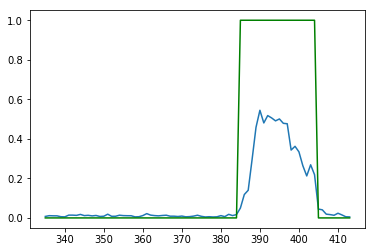

In [132]:
# example 1 not noisy only mfcc
prob = mfcc_results.reshape(test_label.shape[0], 474)
true = test_label.reshape(test_label.shape[0], 474)
create_plot(156, prob, true)

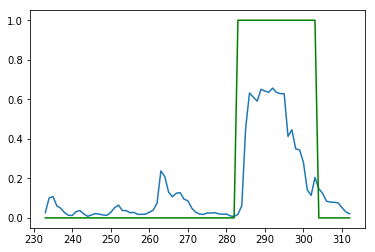

In [148]:
# example 2 not noisy fbank
prob = results.reshape(test_label.shape[0], 474)
create_plot(43, prob, true)

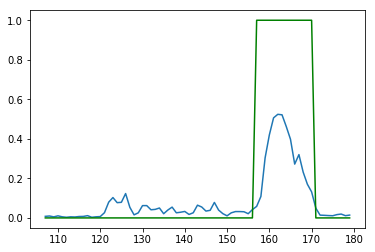

In [33]:
##### test noisy #######

# example 2 noisy only mfcc
prob = mfcc_results.reshape(test_label.shape[0], 474)
true = test_label.reshape(test_label.shape[0], 474)
create_plot(422, prob, true)

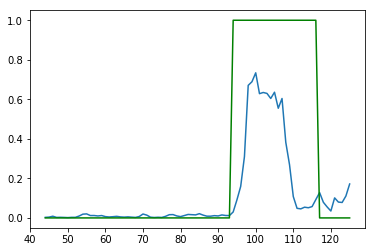

In [35]:
# example 4 noisy fbank
prob = results.reshape(test_label.shape[0], 474)
resd = create_plot(101, prob, true)